In [71]:
import yaml
%matplotlib inline

with open('../coverage-config.yaml') as f:
    config = yaml.load(f)

import pathlib
out_dir = pathlib.Path('out')

/usr/lib/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  """


In [84]:
bio_tree.depths()

{Clade(): 0,
 Clade(branch_length=1.0): 1.0,
 Clade(branch_length=0.5, name='A'): 1.5,
 Clade(branch_length=1.0, name='B'): 2.0,
 Clade(branch_length=1.25, name='C'): 1.25}

/usr/lib/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:7: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  import sys


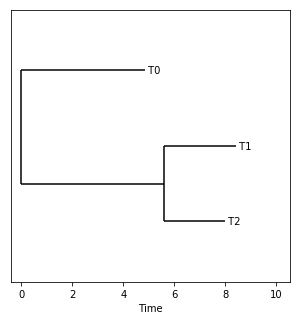

In [107]:
import Bio.Phylo
import io
import matplotlib.pyplot as plt


with open('3taxa/0/run_summary.yaml') as f:
    run_summary = yaml.load(f)
newick_string = run_summary['newick_string']
bio_tree = next(Bio.Phylo.parse(io.StringIO(newick_string), format='newick'))

fig, ax = plt.subplots(figsize=(5, 5))

Bio.Phylo.draw(bio_tree, axes=ax, do_show=False)
ax.set_xlabel('Time');
ax.get_yaxis().set_visible(False)

terminals = bio_tree.get_terminals()
depths = bio_tree.depths()
root_height = max(depths.values())
internal_clade = bio_tree.common_ancestor(terminals[:-1])

In [108]:
import newick
import pylo.topology
import pylo.tree.transform
import numpy as np
from scipy.stats import multivariate_normal
import theano
import theano.tensor as tt

tree = newick.loads(newick_string)[0]
topology = pylo.topology.TreeTopology(tree)
transform = pylo.tree.transform.TreeHeightProportionTransform(topology)

delta = 0.1
x_points = np.arange(-4.0, 4.0, delta)
y_points = np.array(x_points)
X, Y = np.meshgrid(x_points, y_points)
x = X.flatten()
y = Y.flatten()
U = np.column_stack((x, y))

mu = np.zeros(2)
cov = np.eye(2)

Q = multivariate_normal.pdf(U, mu, cov)
Q_grid = Q.reshape(X.shape)
u_ = tt.vector()
t_ = transform.backward(u_)
jacobian_det_ = transform.jacobian_det(u_)

backward_func = theano.function([u_], t_)
jacobian_func = theano.function([u_], jacobian_det_)
T = np.row_stack([backward_func(u) for u in U])
jacobian_dets = np.array([jacobian_func(u) for u in U])

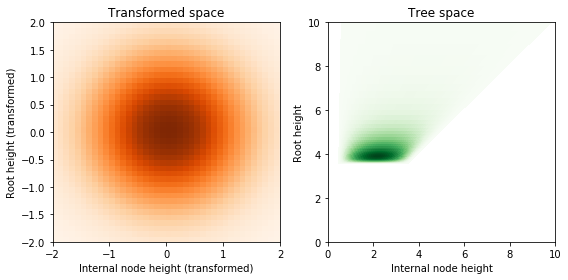

In [110]:
import matplotlib

fig, axs = plt.subplots(ncols=2, figsize=(8, 4))
ax1, ax2 = axs

ax1.pcolormesh(X, Y, Q_grid, cmap='Oranges')
ax1.set_xlim((-2, 2))
ax1.set_ylim((-2, 2))
ax1.set_xlabel('Internal node height (transformed)')
ax1.set_ylabel('Root height (transformed)')
ax1.set_title('Transformed space')

P_grid = Q_grid/np.exp(jacobian_dets.reshape(X.shape))
ax2.pcolormesh(T[:, 0].reshape(X.shape),
               T[:, 1].reshape(Y.shape),
               P_grid,
               cmap='Greens',
               norm=matplotlib.colors.Normalize(vmin=0, vmax=P_grid.max()))
ax2.set_xlim((0, 10))
ax2.set_ylim((0, 10));

ax2.set_xlabel('Internal node height')
ax2.set_ylabel('Root height')
ax2.set_title('Tree space');

plt.tight_layout()
plt.savefig(str(out_dir / 'transform_plot.png'))

In [159]:
import sys
sys.path += ['..']
import topology_inference
import templating
build_templates = templating.TemplateBuilder('3taxa/0')

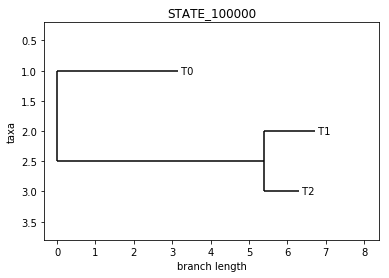

In [160]:
with open(build_templates.beast_analysis_tree_path) as f:
    beast_trees = list(Bio.Phylo.parse(f, format='nexus'))[int(config['chain_length']/config['log_every']*config['burn_in']):]
Bio.Phylo.draw(beast_trees[0])

In [140]:
def get_tree_stats(mcmc_tree):
    depths = mcmc_tree.depths()
    root_height = max(depths.values())
    internal_node = mcmc_tree.common_ancestor('T1', 'T2')
    internal_node_height = root_height - depths[internal_node]
    return [root_height, internal_node_height]

tree_stats = np.array([get_tree_stats(mcmc_tree) for mcmc_tree in beast_trees])
beast_root_heights = tree_stats[:, 0]
beast_internal_node_heights = tree_stats[:, 1]

In [162]:
import pickle
with open(build_templates.pymc_analysis_result_path, 'rb') as f:
    approx = pickle.load(f)

In [165]:
lsd_tree = topology_inference.extract_lsd_tree(build_templates)
import io
newick_io = io.StringIO()
Bio.Phylo.write([lsd_tree], newick_io, format='newick')
lsd_newick = newick_io.getvalue()
lsd_newick

'(T0:5.07190,(T2:1.29085,T1:1.70915):6.92810):0.00000;\n'

In [172]:
lsd_tree = newick.loads(lsd_newick)[0]
lsd_topology = pylo.topology.TreeTopology(lsd_tree)
lsd_transform = pylo.tree.transform.TreeHeightProportionTransform(lsd_topology)
tree_means = approx.groups[0].bij.rmap(approx.mean.eval())['tree_tree_height_proportion__']
tree_sds = approx.groups[0].bij.rmap(approx.std.eval())['tree_tree_height_proportion__']
tree_means

array([-1.53302986,  1.59853158])

In [173]:
X.shape

(80, 80)

In [174]:
y.shape

(6400,)

In [180]:
tree_sds

array([0.71627792, 0.36398664])

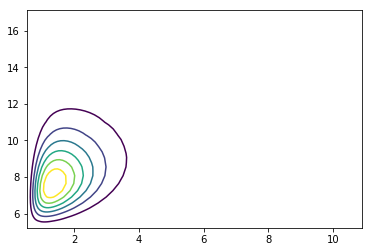

In [198]:
x_min = tree_means[0] - 3*tree_sds[0]
x_max = tree_means[0] + 3*tree_sds[0]
y_min = tree_means[1] - 3*tree_sds[1]
y_max = tree_means[1] + 3*tree_sds[1]

x_points = np.arange(x_min, x_max, delta)
y_points = np.arange(y_min, y_max, delta)
X, Y = np.meshgrid(x_points, y_points)
q_f = multivariate_normal(mean=tree_means, cov=np.diag(tree_sds ** 2))

x = X.flatten()
y = Y.flatten()
U = np.column_stack((x, y))

u_ = tt.vector()
t_ = transform.backward(u_)
jacobian_det_ = transform.jacobian_det(u_)

backward_func = theano.function([u_], t_)
jacobian_func = theano.function([u_], jacobian_det_)

T = np.row_stack([backward_func(u) for u in U])
jacobian_dets = np.array([jacobian_func(u) for u in U])

q_trans = q_f.pdf(U)

In [ ]:
ax.get_xl

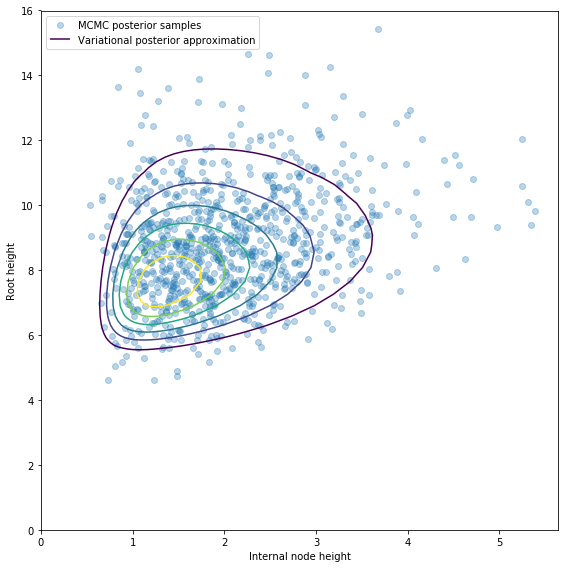

In [211]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(beast_internal_node_heights, beast_root_heights, alpha=0.3, label='MCMC posterior samples')

xlim = ax.get_xlim()
ylim = ax.get_ylim()
cs = ax.contour(T[:, 0].reshape(X.shape), T[:, 1].reshape(X.shape), (q_trans / np.exp(jacobian_dets)).reshape(X.shape))
cs.collections[0].set_label('Variational posterior approximation')

ax.set_xlim((0,xlim[1]))
ax.set_ylim((0, ylim[1]))

ax.set_xlabel('Internal node height')
ax.set_ylabel('Root height')

ax.legend()
plt.tight_layout()
plt.savefig(str(out_dir / 'tree_posterior.png'))